In [1]:
import sys
sys.path.append('../')

import tquant as tq
from engine.globalconfig import GlobalConfig
from engine.loader.curveload import MarketDataLoader

import tensorflow as tf
import tensorflow_probability as tfp

# Settings

In [2]:
config = GlobalConfig.from_json()
mdl = MarketDataLoader(config)

In [3]:
tq.Settings.evaluation_date

datetime.date(2023, 9, 29)

In [4]:
calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

# Market

In [5]:
rates = mdl.ir_eur_curve_estr['quote'].values
times = mdl.ir_eur_curve_estr['daycount'].values/365

rates_6m = mdl.ir_eur_curve_6m['quote'].values
times_6m = mdl.ir_eur_curve_6m['daycount'].values/365

In [6]:
estr_curve = tq.RateCurve(times, rates)
eur6m_curve = tq.RateCurve(times_6m, rates_6m)

# Cap

In [7]:
floating_schedule = [tq.TARGET().advance(evaluation_date,
                         t,
                         tq.TimeUnit.Months,
                         tq.BusinessDayConvention.ModifiedFollowing) for t in [0,6,12,18,24]]
notionals = [1e6] * (len(floating_schedule) - 1)

spreads = [0] * (len(floating_schedule) - 1)
gearing = [1] * (len(floating_schedule) - 1)

index = tq.IborIndex('EUR6M',
             calendar,
             6,
             tq.TimeUnit.Months)

floating_leg = tq.FloatingRateLeg(floating_schedule,
                               notionals,
                               gearing,
                               spreads,
                               index,
                               daycounter)
strike = 0.02
sigma = 0.54

In [8]:
cap = tq.Cap(floating_leg, strike)

In [9]:
option = cap
term_structure = eur6m_curve
#
flows = floating_leg.leg_flows()
c = flows[0]
sign = 1
T = daycounter.year_fraction(evaluation_date, c.date)
######
f = term_structure.forward_rate(c.fixing_date, c.index.fixing_maturity(c.fixing_date), c.day_counter, evaluation_date)
st_dev = sigma
discount = tf.cast(estr_curve.discount(T), tf.float32)
discounted_accrual = c.nominal * floating_leg.gearings[0] * c.accrual_period
displacement = 0

In [10]:
cap_value = 0
for c in flows:
    T = daycounter.year_fraction(evaluation_date, c.date)
    f = term_structure.forward_rate(c.fixing_date, c.index.fixing_maturity(c.fixing_date), c.day_counter, evaluation_date)
    f = tf.cast(f, tf.float32)
    st_dev = tf.math.sqrt(sigma*sigma*T)
    discount = tf.cast(estr_curve.discount(T), tf.float32)
    discounted_accrual = c.nominal * floating_leg.gearings[0] * c.accrual_period
    #####
    forward = tf.cast(f + displacement, tf.float32)
    strike = option.strike

    d1 = tf.math.log(f / strike)/st_dev + 0.5*st_dev
    d1 = tf.cast(d1, tf.float32)
    d2 = d1 - sigma
    phi = tfp.distributions.Normal(0,1)
    nd1 = phi.cdf(sign * d1) 
    nd2 = phi.cdf(sign * d2)

    optionlet_result = discounted_accrual * sign * (forward*nd1 - strike*nd2)
    cap_value += optionlet_result

In [11]:
cap_value

<tf.Tensor: shape=(), dtype=float32, numpy=37895.87>

In [12]:
cap.atm_rate

# QuantLib

In [13]:
import QuantLib as ql
from datetime import datetime

In [14]:
calc_date = ql.Date.from_date(evaluation_date)
ql.Settings.instance().evaluationDate = calc_date

In [15]:
ql_dates = [ql.Date.from_date(t) for t in mdl.ir_eur_curve_6m['maturity'].values]
yields = [r.numpy() for r in eur6m_curve.rates]
day_count = ql.ActualActual()
calendar = ql.TARGET()
interpolation = ql.Linear()
compounding = ql.Compounded
compounding_frequency = ql.Annual

term_structure = ql.ZeroCurve(ql_dates[:28], yields[:28], day_count, calendar, 
                       interpolation, compounding, compounding_frequency)
ts_handle = ql.YieldTermStructureHandle(term_structure)

TypeError: Wrong number or type of arguments for overloaded function 'new_ActualActual'.
  Possible C/C++ prototypes are:
    QuantLib::ActualActual::ActualActual(QuantLib::ActualActual::Convention,Schedule const &)
    QuantLib::ActualActual::ActualActual(QuantLib::ActualActual::Convention)


In [ ]:
start_date = ql.Date(29, 9, 2023)
end_date = ql.Date(29, 9 , 2025)
period = ql.Period(6, ql.Months)
calendar = ql.TARGET()
buss_convention = ql.ModifiedFollowing
rule = ql.DateGeneration.Forward
end_of_month = False

schedule = ql.Schedule(start_date, end_date, period,
                       calendar, buss_convention, buss_convention, 
                       rule, end_of_month)

ibor_index = ql.Euribor6M(ts_handle)
ibor_index.addFixing(ql.Date(27,9,2023), 0.0065560)

ibor_leg = ql.IborLeg([1000000], schedule, ibor_index)

strike = 0.02
cap = ql.Cap(ibor_leg, [strike])

vols = ql.QuoteHandle(ql.SimpleQuote(0.54))
engine = ql.BlackCapFloorEngine(ts_handle, vols)

cap.setPricingEngine(engine)

In [ ]:
cap.setPricingEngine(engine)
print( cap.NPV())

24227.230276858332


# from surface

In the above exercise, we used a constant volatility value. In practice, one needs to strip the market quoted capfloor volatilities to infer the volatility of each and every caplet. QuantLib provides excellent tools in order to do that. Let us assume the following dummy data represents the volatility surface quoted by the market. I have the various strikes, expiries, and the volatility quotes in percentage format. I take the raw data and create a Matrix in order to construct the volatility surface.

In [ ]:
strikes = [0.01,0.015, 0.02]
expiries = [ql.Period(i, ql.Years) for i in range(1,11)] + [ql.Period(12, ql.Years)]
vols = ql.Matrix(len(expiries), len(strikes))
data = [[47.27, 55.47, 64.07, 70.14, 72.13, 69.41, 72.15, 67.28, 66.08, 68.64, 65.83],
   [46.65,54.15,61.47,65.53,66.28,62.83,64.42,60.05,58.71,60.35,55.91],
   [46.6,52.65,59.32,62.05,62.0,58.09,59.03,55.0,53.59,54.74,49.54]
   ]

for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[j][i]/100.0

The CapFloorTermVolSurface offers a way to store the capfloor volatilities. These are however CapFloor volatilities, and not the volatilities of the individual options.



In [ ]:
calendar = ql.UnitedStates()
bdc = ql.ModifiedFollowing
daycount = ql.Actual365Fixed()
settlement_days = 2
capfloor_vol = ql.CapFloorTermVolSurface(settlement_days, calendar, bdc, expiries, strikes, vols, daycount)

The OptionletStripper1 class lets you to strip the individual caplet/floorlet volatilities from the capfloor volatilities. We have to 'jump' some hoops here to make it useful for pricing. The OptionletStripper1 class does not allow you to be consumed directly by a pricing engine. The StrippedOptionletAdapter takes the stripped optionlet volatilities, and creates a term structure of optionlet volatilities. We then wrap that into a handle using OptionletVolatilityStructureHandle.

In [ ]:
optionlet_surf = ql.OptionletStripper1(capfloor_vol, ibor_index)
ovs_handle = ql.OptionletVolatilityStructureHandle(
    ql.StrippedOptionletAdapter(optionlet_surf)
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

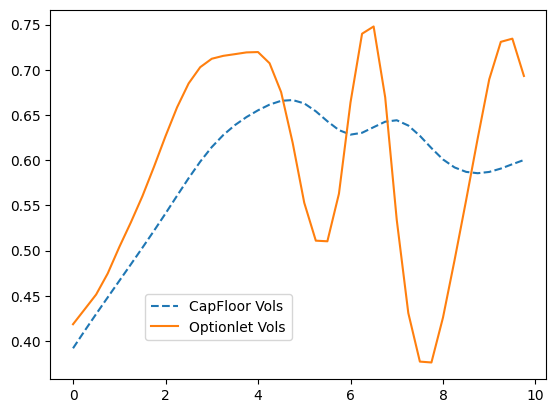

In [ ]:
tenors = np.arange(0,10,0.25)
strike = 0.015
capfloor_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
opionlet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

plt.plot(tenors, capfloor_vols, "--", label="CapFloor Vols")
plt.plot(tenors, opionlet_vols,"-", label="Optionlet Vols")
plt.legend(bbox_to_anchor=(0.5, 0.25))

The BlackCapFloorEngine can accept the optionlet volatility surface in order to price the caps or floors.

In [ ]:
engine2 = ql.BlackCapFloorEngine(ts_handle, ovs_handle)
cap.setPricingEngine(engine2)
print( cap.NPV())

54384.928314950135
